In diesem Notebook werden Bilder mit den assoziierten Sensordaten dargestellt.

In [1]:
# Import von Bibliotheken
import os
import pandas
from scipy.interpolate import interp1d
import numpy as np
import cv2
from ipyleaflet import *

In [2]:
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../merkmale.csv")
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartZeitfenster,StartBewegungsdaten,StartBelichtung,Belichtungszeit,MittelX,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,2.785600e+04,27856.000000,27856.000000,27856.000000,27856.000000,2.785600e+04,2.785600e+04,2.785600e+04,2.785600e+04,27856.000000,...,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000
mean,1.521166e+12,53.627012,10.170418,14.133367,19.396934,5.080487e+13,5.080480e+13,5.080490e+13,1.582498e+07,0.000381,...,2.328667,14.227743,22.141935,0.177896,0.325422,1.279985,3.080109,3.896315,0.384415,0.389947
std,4.224386e+07,0.014997,0.028270,3.333541,0.574142,1.990028e+13,1.990028e+13,1.990028e+13,8.006422e+06,0.268138,...,4.285979,28.080124,36.787180,0.152335,0.642455,0.830861,2.177347,2.638354,0.173556,0.416378
min,1.521124e+12,53.606853,10.133131,5.004000,6.000000,2.999506e+13,2.999499e+13,2.999509e+13,2.362566e+06,-3.293572,...,0.010420,0.080540,0.037990,0.001280,0.000180,0.102080,0.283800,0.194910,0.035780,0.013420
25%,1.521126e+12,53.613900,10.148494,11.915999,19.000000,3.205724e+13,3.205719e+13,3.205727e+13,1.000184e+07,-0.145935,...,0.535478,2.961235,4.543920,0.060118,0.012970,0.731760,1.720825,2.131645,0.245185,0.113890
50%,1.521128e+12,53.623367,10.160772,14.292000,19.000000,3.418446e+13,3.418441e+13,3.418449e+13,1.000184e+07,0.000884,...,1.128885,6.235220,9.769130,0.130860,0.037880,1.062490,2.497040,3.125560,0.361750,0.194630
75%,1.521211e+12,53.638863,10.190353,16.524002,20.000000,7.191791e+13,7.191784e+13,7.191795e+13,2.000368e+07,0.148890,...,2.483720,13.727218,22.840148,0.257310,0.269005,1.575985,3.705025,4.779135,0.507260,0.518655
max,1.521213e+12,53.656776,10.229659,24.768002,24.000000,7.412144e+13,7.412139e+13,7.412146e+13,3.287369e+07,2.119203,...,182.107430,506.214760,569.266520,1.238870,5.701840,13.494720,22.499220,23.859310,1.113050,2.387850


In [4]:
featuresDf.columns

Index(['Zeitstempel', 'Breitengrad', 'Laengengrad', 'Geschwindigkeit',
       'AccelerometerX', 'AccelerometerY', 'AccelerometerZ', 'Azimuth', 'Nick',
       'Roll', 'SensorZeitstempel', 'Messwerte', 'StartZeitfenster',
       'StartBewegungsdaten', 'StartBelichtung', 'Belichtungszeit', 'MittelX',
       'MittelY', 'MittelZ', 'MittelNick', 'MittelRoll', 'AzimuthAenderung',
       'VarianzX', 'VarianzY', 'VarianzZ', 'VarianzNick', 'VarianzRoll',
       'AbweichungX', 'AbweichungY', 'AbweichungZ', 'AbweichungNick',
       'AbweichungRoll'],
      dtype='object')

In [7]:
%%time
# Konvertiere Messwerte zu DataFrames
measuredDataList = featuresDf.AccelerometerX.str.split(" ").tolist()
accList = []
accList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    accList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
accXDf = pandas.concat(accList, ignore_index=True)

measuredDataList = featuresDf.AccelerometerY.str.split(" ").tolist()
accList = []
accList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    accList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
accYDf = pandas.concat(accList, ignore_index=True)

measuredDataList = featuresDf.AccelerometerZ.str.split(" ").tolist()
accList = []
accList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    accList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
accZDf = pandas.concat(accList, ignore_index=True)

measuredDataList = featuresDf.Nick.str.split(" ").tolist()
pitchList = []
pitchList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    pitchList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
pitchDf = pandas.concat(pitchList, ignore_index=True)

measuredDataList = featuresDf.Roll.str.split(" ").tolist()
rollList = []
rollList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    rollList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
rollDf = pandas.concat(rollList, ignore_index=True)

measuredDataList = featuresDf.Azimuth.str.split(" ").tolist()
azimuthList = []
azimuthList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    azimuthList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
azimuthDf = pandas.concat(azimuthList, ignore_index=True)

Wall time: 2min 32s


In [6]:
measuredDataList = featuresDf.SensorZeitstempel.str.split(" ").tolist()
timestampsList = []
timestampsList.append(pandas.DataFrame(np.array(measuredDataList[0]).astype(float)).transpose())
for x in measuredDataList[1:]:
    timestampsList.append(pandas.DataFrame(np.array(x).astype(float)).transpose())
sensorTimestampsDf = pandas.concat(timestampsList, ignore_index=True)

In [274]:
# Index von welchem die Messwerte dargestellt werden sollen
row = 4201
# Der erste und letzte Zeitstempel der Messwerte
timestampsMinMax = [sensorTimestampsDf.iloc[row,0],sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any').iloc[0,-1]]
# Belichtungszeit vom Start bis zum Ende
startExposureTime = featuresDf.StartBelichtung.iloc[row] - featuresDf.StartZeitfenster.iloc[row]
exposureTime = [startExposureTime,startExposureTime + featuresDf.Belichtungszeit.iloc[row]]

In [275]:
df = accXDf.iloc[[row]]
# Spalten mit NaN werten werden entfernt
df.dropna(axis=1, how='any')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
4201,-0.91849,-0.62741,-1.03812,-1.27474,-0.49869,2.00685,-0.41703,-1.8045,0.4872,1.04875,-1.70448,-0.93443,-0.13451,0.53606,-0.10734,1.10943,-0.95109,-0.16316,1.53978,0.38918


In [276]:
np.asarray(sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any'))

array([[  4248768.,   4402154.,   6068300.,  10926008.,  13374393.,
         25062570.,  25197622.,  25314185.,  29456060.,  38697570.,
         38904497.,  44013352.,  45190018.,  52581216.,  56245956.,
         57312466.,  61060852.,  66570018.,  71682154.,  72603456.]])

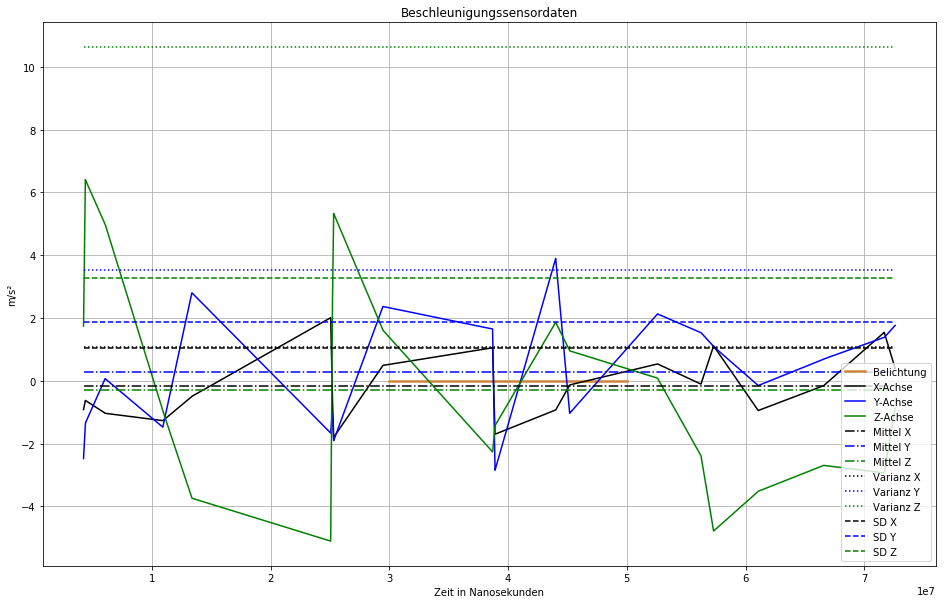

In [277]:
# interp1d interpoliert Werte zwischen den einzelnen Messwerten
npTimestamps = np.asarray(sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any')).squeeze()
fAccX = interp1d(npTimestamps,np.asarray(accXDf.iloc[[row]].dropna(axis=1)).squeeze())
fAccY = interp1d(npTimestamps,np.asarray(accYDf.iloc[[row]].dropna(axis=1)).squeeze())
fAccZ = interp1d(npTimestamps.squeeze(),np.asarray(accZDf.iloc[[row]].dropna(axis=1)).squeeze())
xnew = np.arange(timestampsMinMax[0],timestampsMinMax[1],1000)
fig = plt.figure(figsize=(16,10))
ax  = fig.add_subplot(111)
ax.plot(exposureTime,[0,0],color='peru', linewidth=2.5, label='Belichtung')
ax.plot(xnew,fAccX(xnew),color='black', linestyle='-', label='X-Achse')
ax.plot(xnew,fAccY(xnew),color='blue', linestyle='-', label='Y-Achse')
ax.plot(xnew,fAccZ(xnew),color='green', linestyle='-', label='Z-Achse')
ax.plot(timestampsMinMax,[featuresDf.MittelX.iloc[row],featuresDf.MittelX.iloc[row]], color='black', linestyle='-.', label='Mittel X')
ax.plot(timestampsMinMax,[featuresDf.MittelY.iloc[row],featuresDf.MittelY.iloc[row]], color='blue', linestyle='-.', label='Mittel Y')
ax.plot(timestampsMinMax,[featuresDf.MittelZ.iloc[row],featuresDf.MittelZ.iloc[row]], color='green', linestyle='-.', label='Mittel Z')
ax.plot(timestampsMinMax,[featuresDf.VarianzX.iloc[row],featuresDf.VarianzX.iloc[row]], color='black', linestyle=':', label='Varianz X')
ax.plot(timestampsMinMax,[featuresDf.VarianzY.iloc[row],featuresDf.VarianzY.iloc[row]], color='blue', linestyle=':', label='Varianz Y')
ax.plot(timestampsMinMax,[featuresDf.VarianzZ.iloc[row],featuresDf.VarianzZ.iloc[row]], color='green', linestyle=':', label='Varianz Z')
ax.plot(timestampsMinMax,[featuresDf.AbweichungX.iloc[row],featuresDf.AbweichungX.iloc[row]], color='black', linestyle='--', label='SD X')
ax.plot(timestampsMinMax,[featuresDf.AbweichungY.iloc[row],featuresDf.AbweichungY.iloc[row]], color='blue',linestyle='--', label='SD Y')
ax.plot(timestampsMinMax,[featuresDf.AbweichungZ.iloc[row],featuresDf.AbweichungZ.iloc[row]], color='green', linestyle='--', label='SD Z')
leg = plt.legend(loc='lower right', framealpha=0.8)
plt.title('Beschleunigungssensordaten')
plt.xlabel('Zeit in Nanosekunden')
plt.ylabel('m/s²')
plt.grid()

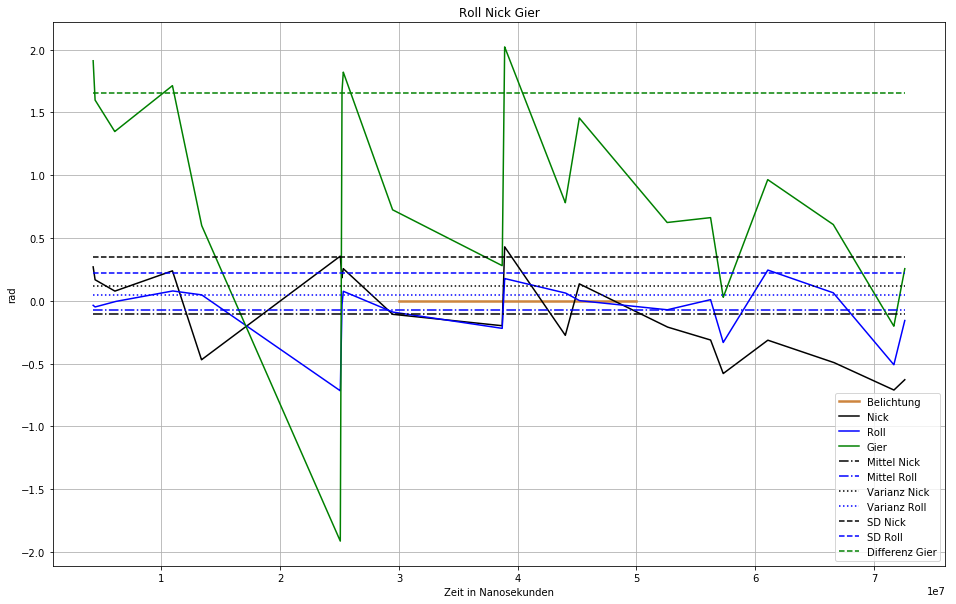

In [278]:
fNick = interp1d(npTimestamps,np.asarray(pitchDf.iloc[[row]].dropna(axis=1)).squeeze())
fRoll = interp1d(npTimestamps,np.asarray(rollDf.iloc[[row]].dropna(axis=1)).squeeze())
fAzimuth = interp1d(npTimestamps,np.asarray(azimuthDf.iloc[[row]].dropna(axis=1)).squeeze())
fig = plt.figure(figsize=(16,10))
ax  = fig.add_subplot(111)
ax.plot(exposureTime,[0,0],color='peru', linewidth=2.5, label='Belichtung')
ax.plot(xnew,fNick(xnew), color='black', linestyle='-', label='Nick')
ax.plot(xnew,fRoll(xnew), color='blue', linestyle='-', label='Roll')
ax.plot(xnew,fAzimuth(xnew), color='green', linestyle='-', label='Gier')
ax.plot(timestampsMinMax,[featuresDf.MittelNick.iloc[row],featuresDf.MittelNick.iloc[row]], color='black', linestyle='-.', label='Mittel Nick')
ax.plot(timestampsMinMax,[featuresDf.MittelRoll.iloc[row],featuresDf.MittelRoll.iloc[row]], color='blue', linestyle='-.', label='Mittel Roll')
ax.plot(timestampsMinMax,[featuresDf.VarianzNick.iloc[row],featuresDf.VarianzNick.iloc[row]], color='black', linestyle=':', label='Varianz Nick')
ax.plot(timestampsMinMax,[featuresDf.VarianzRoll.iloc[row],featuresDf.VarianzRoll.iloc[row]], color='blue', linestyle=':', label='Varianz Roll')
ax.plot(timestampsMinMax,[featuresDf.AbweichungNick.iloc[row],featuresDf.AbweichungNick.iloc[row]], color='black', linestyle='--', label='SD Nick')
ax.plot(timestampsMinMax,[featuresDf.AbweichungRoll.iloc[row],featuresDf.AbweichungRoll.iloc[row]], color='blue', linestyle='--', label='SD Roll')
ax.plot(timestampsMinMax,[featuresDf.AzimuthAenderung.iloc[row],featuresDf.AzimuthAenderung.iloc[row]], color='green', linestyle='--', label='Differenz Gier')
leg = plt.legend(loc='lower right', framealpha=0.8)
plt.title('Roll Nick Gier')
plt.xlabel('Zeit in Nanosekunden')
plt.ylabel('rad')
plt.grid()

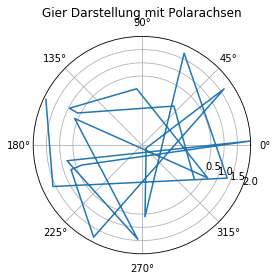

In [279]:
# Darstellung von den Gierwerten in Polarachsen
ax = plt.subplot(111, projection='polar')
ax.plot(npTimestamps,np.asarray(azimuthDf.iloc[[row]].dropna(axis=1)).squeeze())
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2]) 
ax.set_rlabel_position(-22.5)  
ax.grid(True)
ax.set_title("Gier Darstellung mit Polarachsen", va='bottom')
plt.show()

In [75]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['15']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []

In [280]:
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        print(filesPath)
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            images.append(cv2.imread(filesPath + name, cv2.COLOR_BGR2GRAY)) # Bild wird gelesen

E:/bachelor/daten/15/zugeschnitten/1/
E:/bachelor/daten/15/zugeschnitten/2/
E:/bachelor/daten/15/zugeschnitten/3/
E:/bachelor/daten/15/zugeschnitten/4/
E:/bachelor/daten/15/zugeschnitten/5/
E:/bachelor/daten/15/zugeschnitten/6/
E:/bachelor/daten/15/zugeschnitten/7/
E:/bachelor/daten/15/zugeschnitten/8/
E:/bachelor/daten/15/zugeschnitten/1/
E:/bachelor/daten/15/zugeschnitten/2/
E:/bachelor/daten/15/zugeschnitten/3/
E:/bachelor/daten/15/zugeschnitten/4/
E:/bachelor/daten/15/zugeschnitten/5/
E:/bachelor/daten/15/zugeschnitten/6/
E:/bachelor/daten/15/zugeschnitten/7/
E:/bachelor/daten/15/zugeschnitten/8/


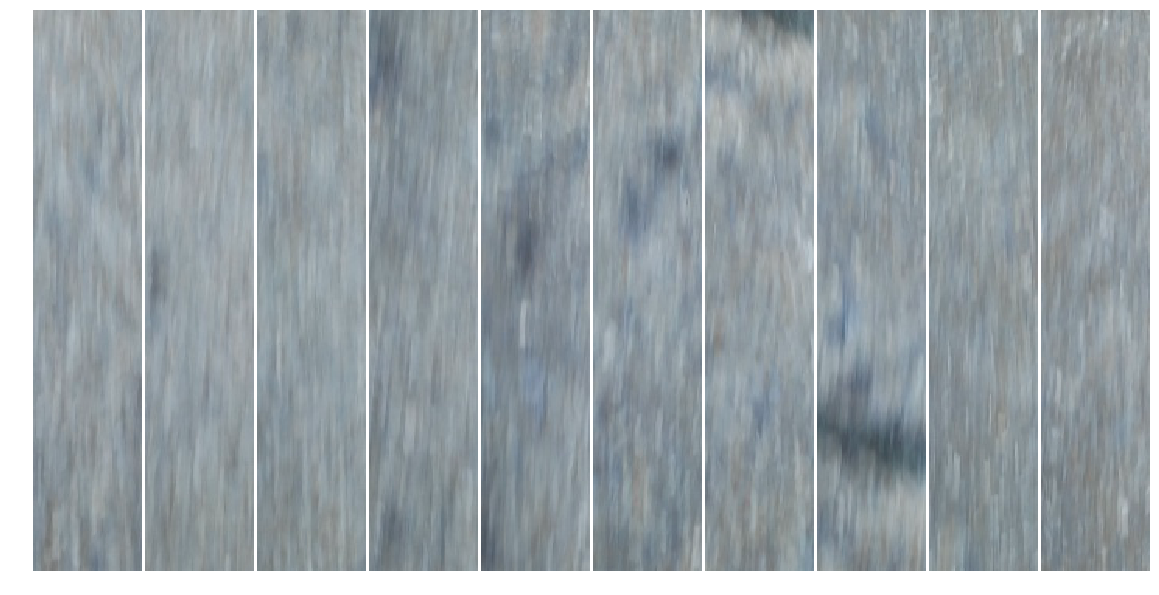

In [281]:
# Plot Beispiel Bilder
fig = plt.figure(1, figsize=(20,20))
# Anzahl der Bilder >= 10
imageToShow = 10
# Start Index des ersten Bildes
startIndex = 4400
grid = ImageGrid(fig, 111, nrows_ncols=(int(imageToShow/10), 10), axes_pad=0.05)
for i, img in enumerate(images[startIndex: startIndex + imageToShow]):
    ax = grid[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

<Figure size 720x720 with 0 Axes>

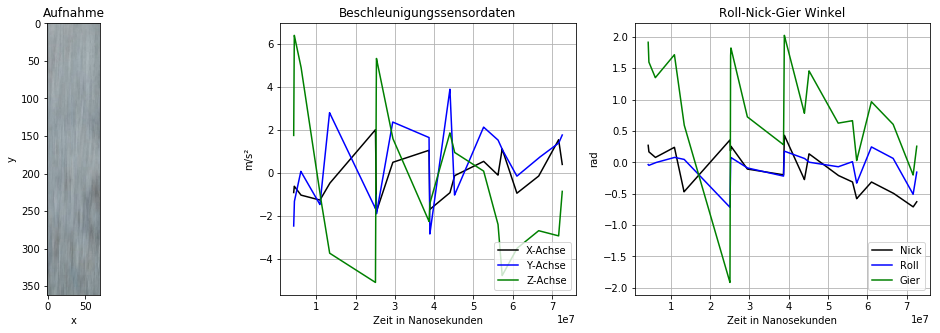

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[53.618809999999996, 10.19853], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Marker(location=[53.618809999999996, 10.19853], opacity=0.5, options=['alt', 'clickable', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'title', 'z_index_offset'])), layout=Layout(height='300px', width='1000px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=16)

In [282]:
# Mit Hilfe eines Subplots werden übersichtlich mehrere Grafiken geplottet
plt.figure(0, figsize=(10,10))
f, axarr = plt.subplots(1, 3,figsize=(18,5))
axarr[0].imshow(images[row], cmap='gray')
axarr[0].set_title('Aufnahme')
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y')
axarr[1].plot(xnew,fAccX(xnew),color='black', linestyle='-', label='X-Achse')
axarr[1].plot(xnew,fAccY(xnew),color='blue', linestyle='-', label='Y-Achse')
axarr[1].plot(xnew,fAccZ(xnew),color='green', linestyle='-', label='Z-Achse')
axarr[1].set_title('Beschleunigungssensordaten')
axarr[1].set_xlabel('Zeit in Nanosekunden')
axarr[1].set_ylabel('m/s²')
axarr[1].grid(True)
axarr[1].legend(loc='lower right', framealpha=0.8)
axarr[2].plot(xnew,fNick(xnew), color='black', linestyle='-', label='Nick')
axarr[2].plot(xnew,fRoll(xnew), color='blue', linestyle='-', label='Roll')
axarr[2].plot(xnew,fAzimuth(xnew), color='green', linestyle='-', label='Gier')
axarr[2].set_title('Roll-Nick-Gier Winkel')
axarr[2].set_xlabel('Zeit in Nanosekunden')
axarr[2].set_ylabel('rad')
axarr[2].grid(True)
axarr[2].legend(loc='lower right', framealpha=0.8)
plt.show()
# Abstand der Subplots
f.subplots_adjust(hspace=0.5)
m = Map(center=(featuresDf.Breitengrad.iloc[row],featuresDf.Laengengrad.iloc[row]),zoom=16, layout=dict(width='1000px', height='300px'))
mark = Marker( location= m.center, opacity=0.5)
m += mark
m